In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

import numpy as np
import pandas as pd
import pymatgen as mg
from helpers.featurizers import PerovskiteProperty
from helpers.plotting import sliceformula_from_tuple
from helpers.quaternary_plt import QuaternaryAxes
import ternary
from ternary.helpers import simplex_iterator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from dcor import distcorr_array

from sklearn.decomposition import KernelPCA, PCA, SparsePCA, MiniBatchSparsePCA
from sklearn.preprocessing import StandardScaler

loaded calc_chemfeat_2
Created MatProjCalc instance
loaded featurizers


# Generate formulas uniformly distributed throughout BCFZY space

In [2]:
scale = 10
formulas = []
for slice_num in range(scale):
    slice_val = slice_num/scale
    tern_scale = scale - slice_num
    
    formulas += [sliceformula_from_tuple(tup,slice_val,slice_axis='Y',tern_axes=['Co','Fe','Zr']) for tup in simplex_iterator(tern_scale)]
        
len(formulas)

285

In [3]:
quat_df = pd.DataFrame(formulas,columns=['formula'])
Bsite = ['Co','Fe','Zr','Y']
for bs in Bsite:
    quat_df[bs] = 0
for i,f in quat_df['formula'].items():
    comp = mg.Composition(f)
    quat_df.loc[i,Bsite] = [comp.get(bs) for bs in Bsite]
quat_df.head(15)

,formula,Co,Fe,Zr,Y
0,Ba1Co0.0Fe0.0Zr1.0Y0.0O3,0.0,0.0,1.0,0.0
1,Ba1Co0.0Fe0.1Zr0.9Y0.0O3,0.0,0.1,0.9,0.0
2,Ba1Co0.0Fe0.2Zr0.8Y0.0O3,0.0,0.2,0.8,0.0
3,Ba1Co0.0Fe0.3Zr0.7Y0.0O3,0.0,0.3,0.7,0.0
4,Ba1Co0.0Fe0.4Zr0.6Y0.0O3,0.0,0.4,0.6,0.0
5,Ba1Co0.0Fe0.5Zr0.5Y0.0O3,0.0,0.5,0.5,0.0
6,Ba1Co0.0Fe0.6Zr0.4Y0.0O3,0.0,0.6,0.4,0.0
7,Ba1Co0.0Fe0.7Zr0.3Y0.0O3,0.0,0.7,0.3,0.0
8,Ba1Co0.0Fe0.8Zr0.2Y0.0O3,0.0,0.8,0.2,0.0
9,Ba1Co0.0Fe0.9Zr0.1Y0.0O3,0.0,0.9,0.1,0.0


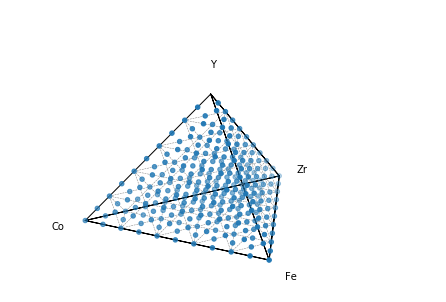

In [4]:
qax = QuaternaryAxes()
qax.draw_axes()
qax.scatter(quat_df.loc[:,Bsite].values)
qax.ax.axis('off')
qax.label_corners(Bsite,offset=0.2)
#qax.axes_ticks()
qax.gridlines()
qax.fill()

# Featurize formulas

In [5]:
"check num features"
#comp features
pp = PerovskiteProperty.from_preset('BCFZY')
pp.ElementProperty.stats = ["mean"]
pp.set_featurize_options(sites='',ox_stats=['mean'])
comp_min = len(pp.feature_labels())
pp.ElementProperty.stats = ["mean", "std_dev", "range"]
pp.set_featurize_options(sites='')
comp_max = len(pp.feature_labels())

#site features
pp.ElementProperty.stats = ["mean"]
pp.set_featurize_options(sites='A',ox_stats=['mean'])
site_min = len(pp.feature_labels()) - comp_min
pp.ElementProperty.stats = ["mean", "std_dev", "range"]
pp.set_featurize_options(sites='A')
site_max = len(pp.feature_labels()) - comp_max

#max features
pp.set_featurize_options(sites=['A','B','X','comp'])
full_max = len(pp.feature_labels())

print(f'Comp: min={comp_min}, max={comp_max}')
print(f'Site: min={site_min}, max={site_max}')
print(f'Overall: max={full_max}')

Comp: min=12, max=67
Site: min=56, max=144
Overall: max=603


In [6]:
pp = PerovskiteProperty.from_preset('BCFZY')
pp.set_featurize_options('B', ox_stats=['mean'],silent=False)
feature_df = pd.DataFrame(formulas,columns=['formula'])
start = time.time()
#pp.set_n_jobs(1)
pp.featurize_dataframe(feature_df,col_id='formula')
elapsed = time.time() - start
print('Total time: {}\nTime per record: {}'.format(elapsed,elapsed/len(formulas)))

HBox(children=(IntProgress(value=0, description='PerovskiteProperty', max=285, style=ProgressStyle(description_width='initial')), HTML(value='')))


Total time: 227.87027072906494
Time per record: 0.7995448095756664


In [53]:
feature_df.head()

,formula,comp_oxmean_goldschmidt,comp_oxmean_goldschmidt_struct,comp_oxmean_tau,comp_oxmean_tot_cat_charge,comp_oxmean_anion_delta,comp_oxmean_alat_hardsphere,comp_oxmean_uc_vol,comp_oxmean_uc_vol_free,comp_oxmean_r_crit,...,Bsite_valence_unfilled_d_range,Bsite_valence_unfilled_f_mean,Bsite_valence_unfilled_f_std_dev,Bsite_valence_unfilled_f_range,Bsite_polarizability_mean,Bsite_polarizability_std_dev,Bsite_polarizability_range,Bsite_sigma_therm_mean,Bsite_sigma_therm_std_dev,Bsite_sigma_therm_range
0,Ba1Co0.0Fe0.0Zr1.0Y0.0O3,1.011129,3.000000,3.432363,6.0,0.00,4.186072,73.353379,23.390939,0.883935,...,0.0,0.0,0.0,0.0,17.90,0.000000,0.0,23.0,0.000000,0.0
1,Ba1Co0.0Fe0.1Zr0.9Y0.0O3,1.013593,3.000000,3.437021,5.9,0.05,4.186072,73.353379,23.937987,0.885700,...,4.0,0.0,0.0,0.0,16.95,6.717514,9.5,28.7,40.305087,57.0
2,Ba1Co0.0Fe0.2Zr0.8Y0.0O3,1.016100,3.000000,3.443696,5.8,0.10,4.186072,73.353379,24.483401,0.887471,...,4.0,0.0,0.0,0.0,16.00,6.717514,9.5,34.4,40.305087,57.0
3,Ba1Co0.0Fe0.3Zr0.7Y0.0O3,1.018653,3.000000,3.452416,5.7,0.15,4.186072,73.353379,25.027204,0.889250,...,4.0,0.0,0.0,0.0,15.05,6.717514,9.5,40.1,40.305087,57.0
4,Ba1Co0.0Fe0.4Zr0.6Y0.0O3,1.021250,2.666667,3.463211,5.6,0.20,4.186715,73.387177,25.603216,0.891370,...,4.0,0.0,0.0,0.0,14.10,6.717514,9.5,45.8,40.305087,57.0


In [54]:
"Calculate pearson and distance correlation matrices"
dt = feature_df.dtypes
nonnumeric = list(dt[dt==np.dtype('O')].index)
drop = [nn for nn in nonnumeric if nn!='formula'] 
drop
X = feature_df.loc[:,'comp_oxmean_goldschmidt':].drop(drop,axis=1).values
X_df = feature_df.loc[:,'comp_oxmean_goldschmidt':].drop(drop,axis=1)
corr = np.corrcoef(X,rowvar=False)
dcorr = distcorr_array(X)

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\OneDrive - Colorado School of Mines\python\misc_modules\dcor.py:34: RuntimeWarning:

invalid value encountered in double_scalars



C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning:

invalid value encountered in less_equal



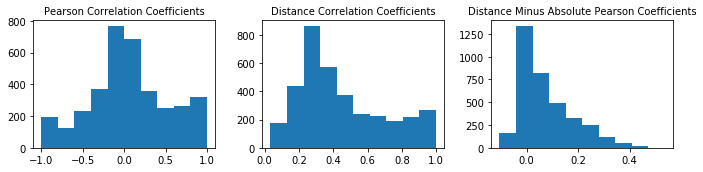

In [55]:
"Compare distributions of correlation coefficients"
#get indices for lower triangle of array (below main diagonal)
tri = np.tril_indices(len(corr),k=-1)
#get coefficients from lower triangle to exclude duplicates (correlation matrices are symmetric)
corr_flat = corr[tri]
dcorr_flat = dcorr[tri]

fig, axes = plt.subplots(1,3,figsize=(10,2.5))
axes[0].hist(corr_flat)
axes[0].set_title('Pearson Correlation Coefficients',size=10)
axes[1].hist(dcorr_flat)
axes[1].set_title('Distance Correlation Coefficients',size=10)
corr_diff = dcorr_flat - np.abs(corr_flat)
axes[2].hist(corr_diff)
axes[2].set_title('Distance Minus Absolute Pearson Coefficients',size=10)
fig.tight_layout()

# Identify feature correlation groups

In [61]:
hi_corr = np.where(np.abs(np.triu(dcorr,1))>=0.98)#np.where(np.abs(np.triu(corr,1))>=0.98)
hi_corr

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in greater_equal



(array([ 0,  0,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  9, 11, 11,
        11, 11, 13, 13, 13, 18, 18, 19, 21, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 25, 25, 25, 25, 25, 26, 29, 29, 29, 31, 31, 31, 31,
        31, 31, 31, 31, 36, 36, 36, 36, 36, 36, 36, 38, 38, 38, 38, 40, 40,
        40, 42, 42, 42, 42, 46, 46, 49, 51, 52, 56, 56, 59, 60, 62, 62, 62,
        63, 64, 77, 79, 92, 92], dtype=int64),
 array([  9,  68,   4,  11,  13,  46,  50,  83,  11,  13,  46,  50,  83,
          6,  68,  13,  46,  50,  83,  46,  50,  83,  19,  20,  20,  33,
         25,  31,  36,  38,  40,  42,  56,  59,  62,  92,  98, 101,  29,
         31,  56,  59,  65,  27,  56,  59,  65,  36,  42,  56,  59,  62,
         92,  98, 101,  38,  40,  42,  62,  92,  98, 101,  40,  42,  62,
         92,  42,  62,  92,  62,  92,  98, 101,  50,  83,  85,  84,  85,
         59,  65,  65,  66,  92,  98, 101,  93,  94,  98, 100,  98, 101],
       dtype=int64))

In [67]:
def get_linked_groups(correlated_columns):
    """
    Get groups of directly and indirectly correlated columns
    """
    groups = []
    for num in np.unique(correlated_columns[0]):
        in_set = [num in numset for numset in groups]
        if max(in_set,default=False)==False:
            #if not already in a set, get correlated var nums and check if they belong to an existing set
            cnums = correlated_columns[1][np.where(correlated_columns[0]==num)]
            numset = set([num] + list(cnums))
            #check if numset intersects an existing set
            intersect = [numset & group for group in groups]
            if len(intersect) > 0:
                intersect_group = intersect[np.argmax(intersect)]
            else:
                intersect_group = []
            #if intersects existing set, add to set
            if len(intersect_group) > 0:
                intersect_group |= numset
                #print('existing group:', num, intersect_group)
            #otherwise, make new set
            else:
                groups.append(numset)
                #print('new group:', num, cnums)
        else:
            #if already in a set, get correlated var nums and add to set
            group = groups[in_set.index(True)]
            cnums = correlated_columns[1][np.where(correlated_columns[0]==num)]
            group |= set(cnums) #union
            #print('existing group:', num, group)
    return groups

In [69]:
hc_groups = get_linked_groups(hi_corr)
hc_groups

[{0, 9, 68},
 {3, 4, 11, 13, 46, 50, 83},
 {5, 6},
 {18, 19, 20},
 {21, 33},
 {22, 25, 29, 31, 36, 38, 40, 42, 56, 59, 62, 65, 92, 98, 101},
 {26, 27},
 {49, 85},
 {51, 84},
 {60, 66},
 {63, 93},
 {64, 94},
 {79, 100}]

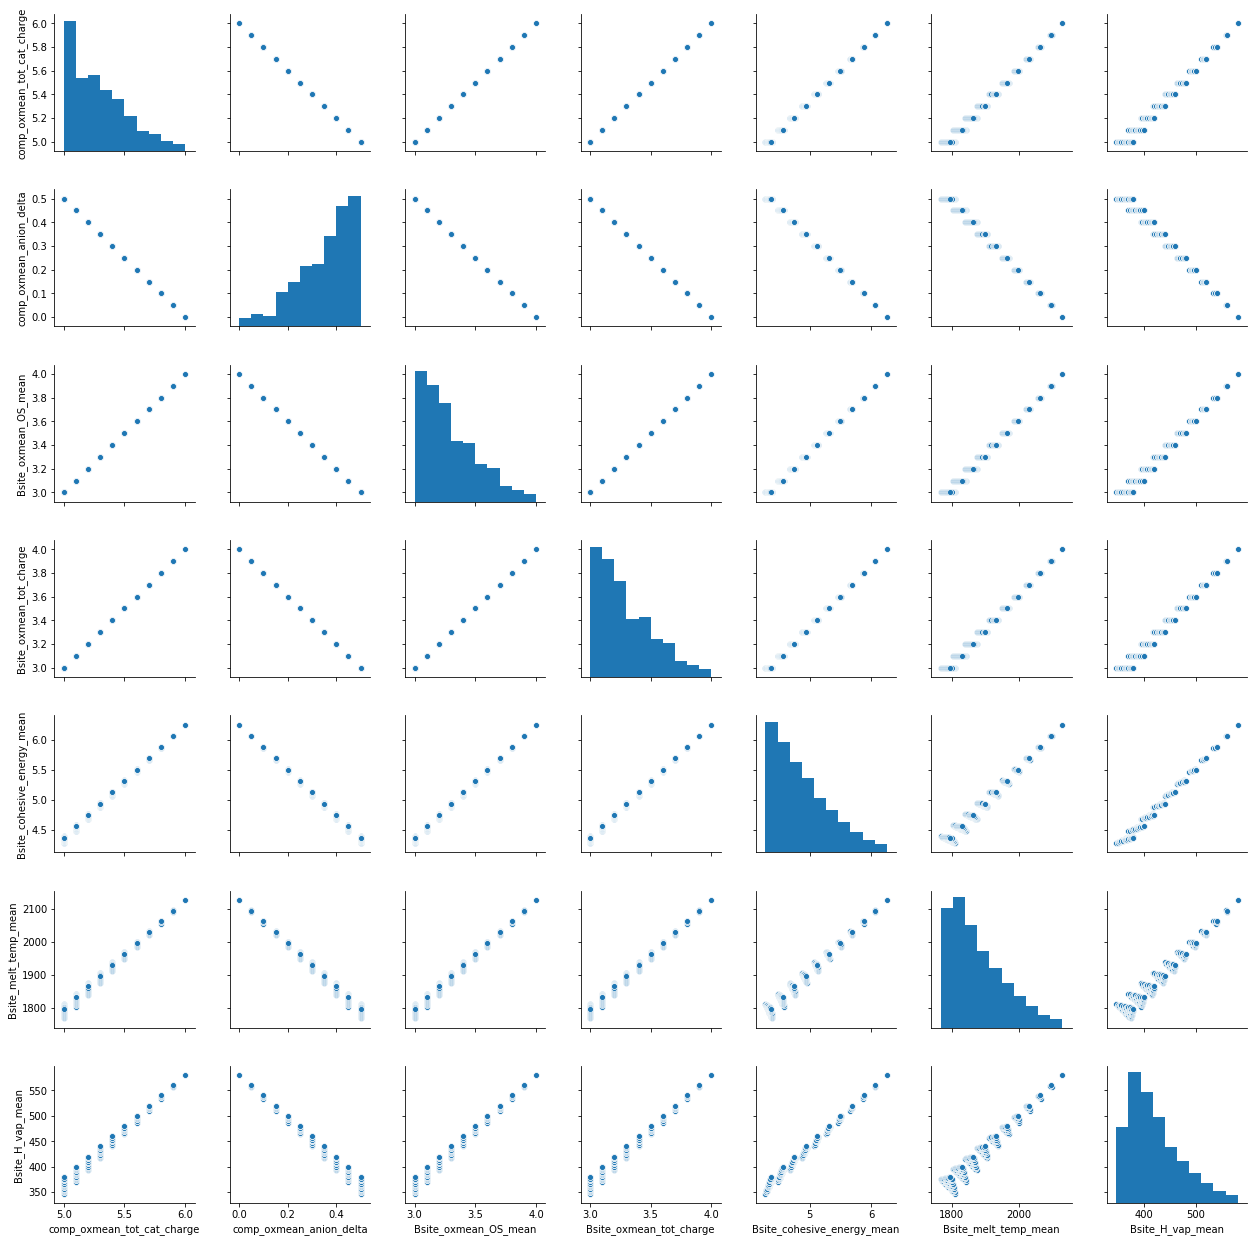

In [70]:
group_num = 1
grp_df = X_df.iloc[:,list(hc_groups[group_num])]
sns.pairplot(grp_df)

In [81]:
X_df.columns[list(hd_groups[1])]

Index(['Bsite_polarizability_std_dev', 'Bsite_oxmean_OS_std'], dtype='object')

In [77]:
hi_diff
np.array([hi_diff[0],hi_diff[1]]).T

array([[  7,  18],
       [ 12,  99],
       [ 18,  23],
       [ 22,  30],
       [ 23,  25],
       [ 23,  29],
       [ 23,  59],
       [ 23,  65],
       [ 25,  30],
       [ 29,  30],
       [ 30,  31],
       [ 30,  36],
       [ 30,  42],
       [ 30,  56],
       [ 30,  59],
       [ 30,  62],
       [ 30,  65],
       [ 30,  92],
       [ 30,  98],
       [ 30, 101],
       [ 48,  78],
       [ 48,  79],
       [ 48,  99],
       [ 49,  78],
       [ 49,  99],
       [ 78,  81]], dtype=int64)

In [71]:
diff = dcorr - np.abs(corr)
hi_diff = np.where(np.abs(np.triu(diff,1)) >= 0.4)
hd_groups = get_linked_groups(hi_diff)
hd_groups

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in greater_equal



[{7, 18, 23, 25, 29, 30, 31, 36, 42, 56, 59, 62, 65, 92, 98, 101},
 {12, 99},
 {22, 30},
 {78, 81}]

<IPython.core.display.Javascript object>


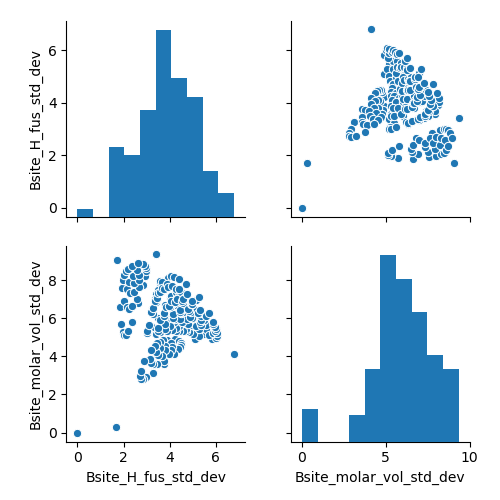

In [83]:
%matplotlib notebook
group_num = 3
grp_df = X_df.iloc[:,list(hd_groups[group_num])]
sns.pairplot(grp_df)

# PCA

In [84]:
"Generate full feature set for PCA"
pp.set_featurize_options(sites=['comp','B'],ox_stats=['min','max','mean','std','range'])
fullfeature_df = pd.DataFrame(formulas,columns=['formula'])
start = time.time()
#pp.set_n_jobs(1)
pp.featurize_dataframe(fullfeature_df,col_id='formula')
elapsed = time.time() - start
print('Total time: {}\nTime per record: {}'.format(elapsed,elapsed/len(formulas)))

HBox(children=(IntProgress(value=0, description='PerovskiteProperty', max=285, style=ProgressStyle(description_width='initial')), HTML(value='')))


Total time: 188.95785808563232
Time per record: 0.6630100283706397


In [108]:
fdt = fullfeature_df.dtypes
nonnumeric = fdt[fdt==np.dtype('O')]
isnull = fullfeature_df.isnull().max()
nulls = isnull[isnull==True]
nulls
drop = list(nulls.index) + list(nonnumeric.index)
fX_df = fullfeature_df.drop(drop,axis=1)
fX_df.head()

,comp_oxmin_goldschmidt,comp_oxmin_goldschmidt_struct,comp_oxmin_tau,comp_oxmin_tot_cat_charge,comp_oxmin_anion_delta,comp_oxmin_alat_hardsphere,comp_oxmin_uc_vol,comp_oxmin_uc_vol_free,comp_oxmin_r_crit,comp_oxmax_goldschmidt,...,Bsite_valence_unfilled_d_range,Bsite_valence_unfilled_f_mean,Bsite_valence_unfilled_f_std_dev,Bsite_valence_unfilled_f_range,Bsite_polarizability_mean,Bsite_polarizability_std_dev,Bsite_polarizability_range,Bsite_sigma_therm_mean,Bsite_sigma_therm_std_dev,Bsite_sigma_therm_range
0,1.011129,3.0,3.432363,6.0,0.0,4.186072,73.353379,23.390939,0.883935,1.011129,...,0.0,0.0,0.0,0.0,17.90,0.000000,0.0,23.0,0.000000,0.0
1,1.008206,3.0,3.428367,5.8,0.0,4.186072,73.353379,23.477245,0.881823,1.017766,...,4.0,0.0,0.0,0.0,16.95,6.717514,9.5,28.7,40.305087,57.0
2,1.005301,3.0,3.425152,5.6,0.0,4.186072,73.353379,23.560315,0.879714,1.024491,...,4.0,0.0,0.0,0.0,16.00,6.717514,9.5,34.4,40.305087,57.0
3,1.002412,3.0,3.422715,5.4,0.0,4.186072,73.353379,23.640210,0.877608,1.031306,...,4.0,0.0,0.0,0.0,15.05,6.717514,9.5,40.1,40.305087,57.0
4,0.999540,2.0,3.421053,5.2,0.0,4.186072,73.353379,23.716993,0.876509,1.038212,...,4.0,0.0,0.0,0.0,14.10,6.717514,9.5,45.8,40.305087,57.0


In [116]:
kpca = KernelPCA(kernel='poly',n_components=10,gamma=10)#,fit_inverse_transform=True)
kpca.fit_transform(fX_df.values)

array([[-5.38215175e+13, -6.28278551e+12, -5.83315849e+12, ...,
         1.51273286e+13, -4.63294284e+12,  5.10328668e+11],
       [-2.87433471e+13, -5.18921652e+12, -1.93278880e+13, ...,
         2.83758407e+12,  6.20986743e+11, -6.97884526e+11],
       [-2.80814713e+13, -7.13933923e+12, -1.72831027e+13, ...,
         2.23413558e+12,  5.86522426e+09, -8.85730873e+11],
       ...,
       [-4.75271929e+13,  1.85442184e+13,  4.60807238e+12, ...,
        -1.58786126e+11,  1.20898525e+12,  1.54221545e+12],
       [-3.08119658e+13,  2.27559250e+13,  1.52216647e+13, ...,
        -1.57671021e+12, -2.94829989e+11,  6.26307493e+11],
       [-1.14563755e+13,  2.78231370e+13,  1.68594986e+13, ...,
        -3.60455091e+11, -2.64719293e+12,  2.30982085e+12]])

In [222]:
"standardize data (center and normalize)"
fX = fX_df.values
print(fX.shape)
ss = StandardScaler()
sfX = ss.fit_transform(fX)

(285, 304)


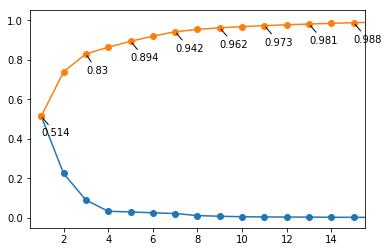

In [257]:
"Standard PCA"
pca = PCA(n_components=None,copy=True)
pca.fit(sfX)#fX_df.values)
comp_nums = np.arange(len(pca.explained_variance_ratio_)) + 1
cumev = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots()
ax.plot(comp_nums,pca.explained_variance_ratio_,'-o',label='Incremental')
ax.plot(comp_nums,cumev,'-o',label='Cumulative')
ax.set_xlim(0.5,15.5)

for x,y in zip(comp_nums[:15:2],cumev[:15:2]):
    ax.annotate(round(y,3),(x,y),xytext=(x+0.0,y-0.1),arrowprops={'arrowstyle':'-'})

(array([61., 14., 10., 16., 17., 40., 16., 11., 21., 98.]),
 array([0.        , 0.00850922, 0.01701844, 0.02552767, 0.03403689,
        0.04254611, 0.05105533, 0.05956455, 0.06807377, 0.076583  ,
        0.08509222]),
 <a list of 10 Patch objects>)

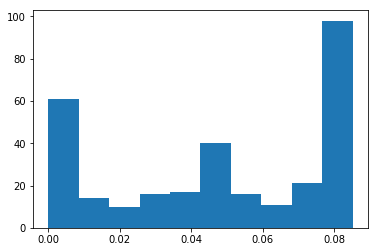

In [258]:
plt.hist(np.abs(pca.components_[0]))

In [259]:
sfX@pca.components_.T/pca.transform(sfX)

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide



array([[ 1.00027223e+00,  9.99989881e-01,  1.00000525e+00, ...,
        -6.43285660e+14,  4.97032742e+12, -2.58072835e+15],
       [ 1.00034315e+00,  9.99988235e-01,  1.00003662e+00, ...,
        -2.14428553e+14, -5.46736016e+13,  2.45783653e+14],
       [ 1.00046380e+00,  9.99986952e-01,  1.00006223e+00, ...,
        -2.75693854e+14, -2.18694406e+13, -1.93857529e+14],
       ...,
       [ 1.00020630e+00,  1.00001746e+00,  1.00000510e+00, ...,
         1.07214277e+14,  9.50845245e+12, -1.77981266e+14],
       [ 1.00028400e+00,  1.00001067e+00,  1.00001101e+00, ...,
         1.20616061e+14,  3.08020291e+12, -1.98517566e+14],
       [ 1.00029334e+00,  1.00001056e+00,  1.00001458e+00, ...,
         1.92985698e+14,  4.97032742e+12,  1.66498604e+14]])

In [261]:
sfX@pca.components_.T@pca.components_

array([[ 1.88924849,  3.02961572,  0.21474005, ..., -1.7068248 ,
        -3.4859835 , -3.77949435],
       [ 1.71056849,  3.02961572,  0.03037779, ..., -1.40405816,
         0.07168482, -0.81941887],
       [ 1.53291834,  3.02961572, -0.11793662, ..., -1.10129152,
         0.07168482, -0.81941887],
       ...,
       [-2.59792518, -0.33007486,  7.81494234, ..., -1.99365635,
        -3.11149209, -3.46790746],
       [-2.75164128, -0.33007486,  6.16005434, ..., -1.69088971,
         0.44617623, -0.50783197],
       [-2.66207388, -0.33007486,  5.54191066, ..., -1.5846558 ,
         1.6944809 ,  0.53079101]])

In [272]:
np.sum(np.round(pca.inverse_transform(pca.transform(sfX)),4) == np.round(sfX@pca.components_.T@pca.components_,4)),np.prod(sfX.shape)

(77805, 86640)

In [247]:
pca.transform(sfX)

array([[  1.69889867,   2.55958315,   3.95759314, ...,   0.77704633,
         -3.77219117,   1.55036244],
       [  1.34777233,   2.20133921,   0.56765823, ...,   2.33113898,
          0.34292647, -16.27880563],
       [  0.99716385,   1.98492734,   0.33408131, ...,   1.81310809,
          0.85731617,  20.63919999],
       ...,
       [  2.24177196,  -1.4836708 ,   4.07867312, ...,  -4.66227795,
         -1.9718272 ,  22.48025539],
       [  1.62846262,  -2.42767539,   1.8884307 , ...,  -4.14424707,
         -6.08694484,  20.15471173],
       [  1.57661088,  -2.45314737,   1.42575069, ...,  -2.59015442,
         -3.77219117, -24.03061783]])

In [162]:
np.sort(np.abs(pca.components_[0]))

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.57525356e-33,
       1.02122135e-21, 3.63385972e-21, 8.16977082e-21, 2.75594464e-07,
       3.50140518e-07, 4.52423038e-07, 9.86311719e-07, 1.28200063e-06,
       1.47425590e-06, 1.77390232e-06, 1.86262855e-06, 2.23194139e-06,
       2.24110873e-06, 2.37562947e-06, 2.83629334e-06, 2.83799839e-06,
       2.84175182e-06, 2.89651256e-06, 3.19189234e-06, 3.21825310e-06,
      

(285, 304)


C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in true_divide



(76665, 86640)

In [216]:
help(ss)

Help on StandardScaler in module sklearn.preprocessing.data object:

class StandardScaler(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Standardize features by removing the mean and scaling to unit variance
 |  
 |  Centering and scaling happen independently on each feature by computing
 |  the relevant statistics on the samples in the training set. Mean and
 |  standard deviation are then stored to be used on later data using the
 |  `transform` method.
 |  
 |  Standardization of a dataset is a common requirement for many
 |  machine learning estimators: they might behave badly if the
 |  individual feature do not more or less look like standard normally
 |  distributed data (e.g. Gaussian with 0 mean and unit variance).
 |  
 |  For instance many elements used in the objective function of
 |  a learning algorithm (such as the RBF kernel of Support Vector
 |  Machines or the L1 and L2 regularizers of linear models) assume that
 |  all features are centered around 0 a

In [285]:
spca = MiniBatchSparsePCA(alpha=1)
spca.fit(sfX)
# comp_nums = np.arange(len(spca.explained_variance_ratio_)) + 1
# cumev = np.cumsum(spca.explained_variance_ratio_)

# fig, ax = plt.subplots()
# ax.plot(comp_nums,spca.explained_variance_ratio_,'-o',label='Incremental')
# ax.plot(comp_nums,cumev,'-o',label='Cumulative')
#ax.set_xlim(0.5,10.5)

# for x,y in zip(comp_nums[:10],cumev[:10]):
#     ax.annotate(round(y,3),(x,y),xytext=(x+0.0,y-0.1),arrowprops={'arrowstyle':'-'})

MiniBatchSparsePCA(alpha=1, batch_size=3, callback=None, method='lars',
          n_components=None, n_iter=100, n_jobs=1, random_state=None,
          ridge_alpha=0.01, shuffle=True, verbose=False)

(array([1., 2., 1., 0., 1., 2., 1., 1., 0., 1.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <a list of 10 Patch objects>)

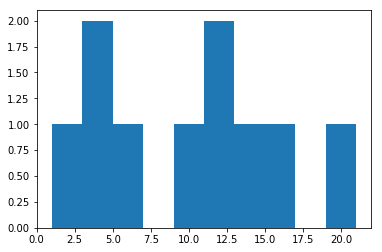

In [286]:
n_features = np.sum(np.sign(np.abs(spca.components_)),axis=1)
plt.hist(n_features[0:10])

In [287]:
n_features

array([21., 15.,  4.,  5., 12., 10., 14., 11.,  1.,  4., 19., 11.,  9.,
        2.,  3.,  9.,  1.,  0.,  1.,  0., 11.,  0.,  0.,  0.,  3.,  4.,
       12., 11.,  3.,  9.,  6., 11., 13.,  5.,  5.,  1.,  7.,  6.,  6.,
        9.,  3.,  0.,  5.,  0.,  0.,  9., 11.,  0.,  5.,  0., 11.,  0.,
        0.,  6.,  3.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  4.,  0.,  1.,
       10., 10.,  5.,  0.,  0.,  9.,  4.,  2.,  0., 10., 11.,  3.,  0.,
        7.,  5.,  3.,  1., 10.,  3., 16., 10.,  5., 10.,  6.,  6.,  9.,
        0.,  6., 10.,  0.,  0.,  2.,  9., 10.,  8.,  0.,  4.,  2.,  5.,
       10.,  8.,  6.,  0.,  0.,  0.,  4.,  6., 17.,  0.,  0.,  4.,  0.,
        6.,  0.,  3.,  9.,  0.,  5.,  4.,  2.,  0.,  0., 12.,  5.,  0.,
       11., 21.,  3.,  5.,  0.,  0.,  0.,  1.,  2.,  2.,  1.,  0.,  0.,
        0.,  5., 11.,  1.,  0.,  4., 11.,  8.,  0.,  0., 10.,  2.,  7.,
        4.,  2.,  5.,  0.,  0., 10.,  3.,  6., 16.,  2.,  9.,  2.,  0.,
        5.,  7.,  8., 12.,  3.,  2.,  9., 12.,  1.,  9.,  0.,  1

In [298]:
211-67

144

In [241]:
np.dot(sfX,spca.components_.T)

array([[-148.83644413,  -21.32290506,  -60.31068338, ...,   22.16475897,
           0.2303559 ,    2.17064973],
       [-111.4419796 ,  -13.46515457,  -26.14716786, ...,   -4.43588326,
           0.2303559 ,   -0.89945133],
       [ -73.95604463,  -13.71841497,   -9.19910724, ...,   -4.43588326,
           0.2303559 ,   -0.89945133],
       ...,
       [-149.95340026,   17.02496698,  -78.79060554, ...,    9.68964246,
           0.2303559 ,   -0.46463015],
       [-112.55114096,   25.18411979,  -68.75346763, ...,    8.02777916,
           0.2303559 ,    2.94910946],
       [-111.75086646,   26.32562022,  -66.89304586, ...,    9.32671948,
           0.2303559 ,    2.91474665]])

In [255]:
sfX@spca.components_.T@spca.components_

array([[ 1.57508259e+03,  6.68895653e+02, -6.14472693e+01, ...,
        -3.69942127e+03, -2.20323403e+03, -2.54380178e+03],
       [ 1.44999689e+03,  6.29016950e+02, -1.03995011e+02, ...,
        -3.02232501e+03, -4.66450240e+01, -3.54095150e+02],
       [ 1.32556561e+03,  6.09840954e+02, -1.43370842e+02, ...,
        -2.34779859e+03,  2.10527125e+00, -3.03953845e+02],
       ...,
       [-2.09137243e+03, -1.76510081e+02,  2.79876022e+03, ...,
        -4.37401122e+03, -1.77940968e+03, -2.12311237e+03],
       [-2.31249242e+03, -1.91453491e+02,  2.35194204e+03, ...,
        -3.68136381e+03,  3.10822738e+02, -2.88735979e+01],
       [-2.23591942e+03, -1.94581388e+02,  2.18284818e+03, ...,
        -3.47084697e+03,  6.12364464e+02,  3.38967579e+02]])

In [256]:
sfX

array([[ 1.88924849,  3.02961572,  0.21474005, ..., -1.7068248 ,
        -3.4859835 , -3.77949435],
       [ 1.71056849,  3.02961572,  0.03037779, ..., -1.40405816,
         0.07168482, -0.81941887],
       [ 1.53291834,  3.02961572, -0.11793662, ..., -1.10129152,
         0.07168482, -0.81941887],
       ...,
       [-2.59792518, -0.33007486,  7.81494234, ..., -1.99365635,
        -3.11149209, -3.46790746],
       [-2.75164128, -0.33007486,  6.16005434, ..., -1.69088971,
         0.44617623, -0.50783197],
       [-2.66207388, -0.33007486,  5.54191066, ..., -1.5846558 ,
         1.6944809 ,  0.53079101]])